# Imports

In [1]:
import json, random
import sys, statistics

In [2]:
from market import Market, Produto

In [3]:
from PIL import Image
from IPython.display import display


# Static Values

In [4]:
CART: dict = {
    'Altura': 65,
    'Largura': 50,
    'Comprimento': 80,
    'PesoMaximo': 460*1000
}

CART['Capacidade'] = CART['Altura'] * CART['Largura'] * CART['Comprimento']

CART

{'Altura': 65,
 'Largura': 50,
 'Comprimento': 80,
 'PesoMaximo': 460000,
 'Capacidade': 260000}

In [5]:
MAX_MONEY: float = 400.0
MAX_ITEMS: int = 10
MAX_CARTS: int = 100
MAX_GENERATIONS: int = 200
BESTS: int = 10

# Funções

In [6]:
m: Market = Market(r"C:\Users\Arklok\Documents\Projetos\gen-algorithm\data\produtos.csv")

In [7]:
def mosaic(cart: list[Produto], row_quantity: int = 5, image_size: tuple[int, int] = (300, 300)) -> None:
    images: list[Image] = [product.show(popup=False).resize(image_size) for product in cart]
    
    mosaic_size: tuple[int, int] = (image_size[0]*row_quantity, image_size[1]*((len(images)//row_quantity)+1))
    
    mosaic: Image = Image.new('RGB', mosaic_size)
    
    for i, image in enumerate(images):
        mosaic.paste(image, (image_size[0]*(i%row_quantity), image_size[1]*(i//row_quantity)))
    
    display(mosaic) 

In [8]:
import plotly.graph_objects as go

def plot_generations(data):
    # Extraindo as iterações e os valores
    iterations = list(data.keys())
    max_values = [data[i]['max'] for i in iterations]
    min_values = [data[i]['min'] for i in iterations]
    avg_values = [data[i]['avg'] for i in iterations]

    # Criando o gráfico
    fig = go.Figure()

    # Adicionando as linhas para cada tipo
    fig.add_trace(go.Scatter(x=iterations, y=max_values, mode='lines+markers', name='Max'))
    fig.add_trace(go.Scatter(x=iterations, y=min_values, mode='lines+markers', name='Min'))
    fig.add_trace(go.Scatter(x=iterations, y=avg_values, mode='lines+markers', name='Avg'))

    # Adicionando título e rótulos
    fig.update_layout(title='Gráfico de Gerações',
                      xaxis_title='Iteração',
                      yaxis_title='Valores',
                      template='plotly')

    # Exibindo o gráfico
    fig.show()

# Genético

### Geração de Indivíduos

In [9]:
def gerar_carrinho(tamanho: int = globals()['MAX_ITEMS']) -> list[Produto]:
    compra = []

    while len(compra) < tamanho:
        item: Produto = m.random()
        compra.append(item)
        
    return compra

In [10]:
c: list[Produto] = gerar_carrinho()
c

[<Produto(id=173742>,
 <Produto(id=1618540>,
 <Produto(id=1616578>,
 <Produto(id=199100>,
 <Produto(id=1446530>,
 <Produto(id=1621539>,
 <Produto(id=457553>,
 <Produto(id=419003>,
 <Produto(id=42870>,
 <Produto(id=711969>]

### Geração de População Inicial

In [11]:
def gerar_populacao(tamanho: int = globals()['MAX_CARTS']) -> list[list[Produto]]:
    return [gerar_carrinho() for _ in range(tamanho)]

In [12]:
p: list[list[Produto]] = gerar_populacao()
p

[[<Produto(id=438230>,
  <Produto(id=1571405>,
  <Produto(id=62145>,
  <Produto(id=146389>,
  <Produto(id=1571858>,
  <Produto(id=181458>,
  <Produto(id=440140>,
  <Produto(id=328762>,
  <Produto(id=104503>,
  <Produto(id=468794>],
 [<Produto(id=431868>,
  <Produto(id=199100>,
  <Produto(id=454150>,
  <Produto(id=86734>,
  <Produto(id=480594>,
  <Produto(id=1614972>,
  <Produto(id=30116>,
  <Produto(id=472426>,
  <Produto(id=467658>,
  <Produto(id=449568>],
 [<Produto(id=465035>,
  <Produto(id=1591027>,
  <Produto(id=75455>,
  <Produto(id=1613312>,
  <Produto(id=419003>,
  <Produto(id=129104>,
  <Produto(id=708620>,
  <Produto(id=1591037>,
  <Produto(id=707>,
  <Produto(id=1111943>],
 [<Produto(id=74215>,
  <Produto(id=409359>,
  <Produto(id=452970>,
  <Produto(id=55835>,
  <Produto(id=1621539>,
  <Produto(id=182374>,
  <Produto(id=1624533>,
  <Produto(id=1440417>,
  <Produto(id=51876>,
  <Produto(id=137290>],
 [<Produto(id=318904>,
  <Produto(id=1614978>,
  <Produto(id=1246070>,
  <Pr

### Avaliação

In [13]:
# def avaliar(individuo: list[Produto], valor_limite: float = globals()['MAX_MONEY']) -> float:
#     valor_compra: float = 0.0
    
#     for item in individuo:
#         valor_compra += item.price

#     if valor_compra > valor_limite:
#         return float('inf')
    
#     else:
#         return valor_compra

In [34]:
def avaliar(individuo: list[Produto], 
            valor_limite: float = globals()['MAX_MONEY'], 
            max_peso: float = globals()['CART']['PesoMaximo'], 
            max_volume: float = globals()['CART']['Capacidade']
            ) -> float:

    valor_compra: float = 0.0
    peso_total: float = 0.0
    volume_total: float = 0.0
    categorias: set = set()
    repeticoes: int = 0

    for item in individuo:
        valor_compra += item.price
        peso_total += item.weight
        volume_item = item.height * item.width * item.depth
        volume_total += volume_item
        
        categorias.add(item.category)
        
        # Contar repetições de produtos
        if individuo.count(item) > 1:
            repeticoes += 1

    # Penalidades
    nota = 0.0

    # Penalidade por exceder o limite de dinheiro
    if valor_compra > valor_limite:
        nota += (valor_compra - valor_limite) # Ajuste de penalidade
    
    # Penalidade por excesso de peso
    if peso_total > max_peso:
        nota += (peso_total - max_peso) / 1000 # Ajuste de penalidade

    # Penalidade por excesso de volume
    if volume_total > max_volume:
        nota += (volume_total - max_volume) / 1000 # Ajuste de penalidade

    # Penalidade por repetição de produtos
    nota += repeticoes  # Penalidade por cada produto repetido

    # Incentivo pela diversidade de categorias
    nota -= len(categorias) # Deduz nota pela diversidade de categorias

    # Final result is the total cost plus penalizations
    return valor_compra + nota


In [35]:
n: float = avaliar(c)
n

-386.39485199999996

In [16]:
def mapear_notas(populacao: list[list[Produto]], order: str = 'asc') -> dict[float, list[Produto]]:
    notas: dict = {avaliar(individuo): individuo for individuo in populacao}
    
    if order == 'asc':
        return dict(sorted(notas.items()))
    
    else:
        return dict(sorted(notas.items(), reverse=True))

In [17]:
nt: dict[float, list[Produto]] = mapear_notas(p)
nt

{107.8: [<Produto(id=1616483>,
  <Produto(id=273343>,
  <Produto(id=145673>,
  <Produto(id=323858>,
  <Produto(id=40815>,
  <Produto(id=1616960>,
  <Produto(id=421704>,
  <Produto(id=711988>,
  <Produto(id=168623>,
  <Produto(id=463524>],
 110.36: [<Produto(id=146389>,
  <Produto(id=293935>,
  <Produto(id=324197>,
  <Produto(id=1461013>,
  <Produto(id=670165>,
  <Produto(id=463524>,
  <Produto(id=181478>,
  <Produto(id=1628306>,
  <Produto(id=528838>,
  <Produto(id=585390>],
 116.6: [<Produto(id=40815>,
  <Produto(id=9176>,
  <Produto(id=324197>,
  <Produto(id=1591037>,
  <Produto(id=1440417>,
  <Produto(id=330820>,
  <Produto(id=74949>,
  <Produto(id=343565>,
  <Produto(id=13089>,
  <Produto(id=796084>],
 121.34999999999998: [<Produto(id=75455>,
  <Produto(id=1377629>,
  <Produto(id=69291>,
  <Produto(id=215282>,
  <Produto(id=804252>,
  <Produto(id=328355>,
  <Produto(id=1623169>,
  <Produto(id=409355>,
  <Produto(id=796083>,
  <Produto(id=180330>],
 126.49999999999997: [<Produto(id=

### Seleção

In [18]:
def torneio(populacao: list[list[Produto]]) -> list[list[Produto]]:
    vencedores: list[list[Produto] | None] = []
    
    while len(vencedores) < 2:
        competidor_1: list[Produto] = random.choice(populacao)
        competidor_2: list[Produto] = random.choice(populacao)
                
        # Seleção do melhor individuo:
        if avaliar(competidor_1) < avaliar(competidor_2):
            vencedor: list[Produto] = competidor_1
        
        else:
            vencedor: list[Produto] = competidor_2
            
        if vencedor not in vencedores:
            vencedores.append(vencedor)
    
    return vencedores

In [19]:
v1: list[list[Produto]] = torneio(p)
v1

[[<Produto(id=124720>,
  <Produto(id=419634>,
  <Produto(id=323858>,
  <Produto(id=1625252>,
  <Produto(id=455623>,
  <Produto(id=457550>,
  <Produto(id=137858>,
  <Produto(id=180330>,
  <Produto(id=135538>,
  <Produto(id=462300>],
 [<Produto(id=584622>,
  <Produto(id=1245489>,
  <Produto(id=365813>,
  <Produto(id=711992>,
  <Produto(id=316558>,
  <Produto(id=97938>,
  <Produto(id=1471540>,
  <Produto(id=72624>,
  <Produto(id=444216>,
  <Produto(id=465118>]]

In [20]:
def roleta_viciada(populacao: list[list[Produto]]) -> list[list[Produto]]:
    fitness_list: list[float] = [1 / avaliar(individuo) for individuo in populacao]
    total_fitness: float = sum(fitness_list)
    probabilities: list[float] = [fitness / total_fitness for fitness in fitness_list]
    
    vencedores: list[list[Produto]] = random.choices(populacao, weights=probabilities, k=2)
    
    return vencedores

In [21]:
v2: list[list[Produto]] = roleta_viciada(p)
v2

[[<Produto(id=690955>,
  <Produto(id=324326>,
  <Produto(id=465051>,
  <Produto(id=457507>,
  <Produto(id=1625254>,
  <Produto(id=450942>,
  <Produto(id=568597>,
  <Produto(id=697131>,
  <Produto(id=584621>,
  <Produto(id=868>],
 [<Produto(id=343039>,
  <Produto(id=1376745>,
  <Produto(id=1384471>,
  <Produto(id=472422>,
  <Produto(id=1622212>,
  <Produto(id=95963>,
  <Produto(id=1245489>,
  <Produto(id=328080>,
  <Produto(id=347653>,
  <Produto(id=711992>]]

In [22]:
def eugenia(populacao: list[list[Produto]], order: str = 'asc') -> list[list[Produto]]:
    notas: dict[float, list[Produto]] = mapear_notas(populacao, order)
    melhores: list[list[Produto]] = list(notas.values())[:globals()['BESTS']]
    
    return melhores

In [23]:
e: list[list[Produto]] = eugenia(p)
e

[[<Produto(id=1616483>,
  <Produto(id=273343>,
  <Produto(id=145673>,
  <Produto(id=323858>,
  <Produto(id=40815>,
  <Produto(id=1616960>,
  <Produto(id=421704>,
  <Produto(id=711988>,
  <Produto(id=168623>,
  <Produto(id=463524>],
 [<Produto(id=146389>,
  <Produto(id=293935>,
  <Produto(id=324197>,
  <Produto(id=1461013>,
  <Produto(id=670165>,
  <Produto(id=463524>,
  <Produto(id=181478>,
  <Produto(id=1628306>,
  <Produto(id=528838>,
  <Produto(id=585390>],
 [<Produto(id=40815>,
  <Produto(id=9176>,
  <Produto(id=324197>,
  <Produto(id=1591037>,
  <Produto(id=1440417>,
  <Produto(id=330820>,
  <Produto(id=74949>,
  <Produto(id=343565>,
  <Produto(id=13089>,
  <Produto(id=796084>],
 [<Produto(id=75455>,
  <Produto(id=1377629>,
  <Produto(id=69291>,
  <Produto(id=215282>,
  <Produto(id=804252>,
  <Produto(id=328355>,
  <Produto(id=1623169>,
  <Produto(id=409355>,
  <Produto(id=796083>,
  <Produto(id=180330>],
 [<Produto(id=47384>,
  <Produto(id=315604>,
  <Produto(id=40815>,
  <Produt

### Crossover e Mutação

In [24]:
def cruzamento(pais: list[list[Produto]], chance: float = 0.8) -> list[list[Produto]]:
    pai_1: list[Produto] = pais[0]
    pai_2: list[Produto] = pais[1]

    probabilidade: float = round(random.uniform(0, 1), 2)

    if probabilidade < chance:
        pos: int = random.randint(0, len(pai_1))

        filho_1: list[Produto] = pai_1[:pos] + pai_2[pos:]
        filho_2: list[Produto] = pai_2[:pos] + pai_1[pos:]

        return [filho_1, filho_2]

    else:
        return [pai_1, pai_2]

In [25]:
f: list[list[Produto]] = cruzamento(v1)
f

[[<Produto(id=124720>,
  <Produto(id=419634>,
  <Produto(id=323858>,
  <Produto(id=1625252>,
  <Produto(id=455623>,
  <Produto(id=457550>,
  <Produto(id=1471540>,
  <Produto(id=72624>,
  <Produto(id=444216>,
  <Produto(id=465118>],
 [<Produto(id=584622>,
  <Produto(id=1245489>,
  <Produto(id=365813>,
  <Produto(id=711992>,
  <Produto(id=316558>,
  <Produto(id=97938>,
  <Produto(id=137858>,
  <Produto(id=180330>,
  <Produto(id=135538>,
  <Produto(id=462300>]]

In [26]:
def mutar(populacao: list[list[Produto]], chance = 0.05) -> list[list[Produto]]: 
    mutados: list[list[Produto]] = []

    for individuo in populacao:
        for pos, alelo in enumerate(individuo):
            mutacao: float = round(random.uniform(0, 1), 3)

            if mutacao < chance:
                novo_gene: str = m.random(ignore_case=[alelo,]) 
                individuo: str = f'{individuo[:pos]}{novo_gene}{individuo[pos+1:]}'

        mutados.append(individuo)
    
    return mutados

In [27]:
mt: list[list[Produto]] = mutar(p)
mt

[[<Produto(id=438230>,
  <Produto(id=1571405>,
  <Produto(id=62145>,
  <Produto(id=146389>,
  <Produto(id=1571858>,
  <Produto(id=181458>,
  <Produto(id=440140>,
  <Produto(id=328762>,
  <Produto(id=104503>,
  <Produto(id=468794>],
 '[<Produto(id=431868>, <Produto(id=199100>, <Produto(id=454150>, <Produto(id=86734>, <Produto(id=480594>, <Produto(id=1614972>, <Produto(id=30116>, <Produto(id=472426>]Product Info\nid: 71969\nname: Água Mineral sem Gás MINALBA Garrafa 1,5 Litros\nsku: 248495\nprice: 3.69\nimage: https://static.paodeacucar.com/img/uploads/1/384/19436384.jpg\nbrand: Minalba\ncategory: bebidas\ndescription: "Para te acompanhar durante todo o dia, Minalba 1,5L sem gás.Água Mineral NaturalPara perto, longe ou inacreditavelmente longe. Afinal, você pode ir para onde quiser. O que importa é curtir o caminho, expandir seus limites e viver novas experiências.Minalba estará sempre com você, alimentando sua vontade de explorar o mundo e o seu melhor. Viva. Cuide do corpo. Cuide da me

# Execução Principal

In [28]:
relatorio: dict[dict[str: float]] = {}

In [29]:
if __name__ == '__main__':
    i: int = 0
    
    while i < MAX_GENERATIONS:
        i+=1

        populacao_inicial: list[list[Produto]] = gerar_populacao()
        populacao_atual: list[list[Produto]] = populacao_inicial.copy()
        geracao: list[list[Produto]] = []

        while len(geracao) < MAX_CARTS - BESTS:
            notas: dict[float, list[Produto]] = mapear_notas(populacao_atual)
            
            pais: list[list[Produto]] = roleta_viciada(populacao_atual)
            filhos: list[list[Produto]] = cruzamento(pais)
            geracao.extend(filhos)
            
        geracao.extend(eugenia(populacao_atual))
        
        relatorio[i]: dict = {'max': max(notas.keys()), 'min': min(notas.keys()), 'avg': statistics.median(notas.keys())}
        
        populacao_atual: list[list[Produto]] = geracao.copy()
        
        sys.stdout.write(f'\rGeração: {i}\n')

Geração: 1
Geração: 2
Geração: 3
Geração: 4
Geração: 5
Geração: 6
Geração: 7
Geração: 8
Geração: 9
Geração: 10
Geração: 11
Geração: 12
Geração: 13
Geração: 14
Geração: 15
Geração: 16
Geração: 17
Geração: 18
Geração: 19
Geração: 20
Geração: 21
Geração: 22
Geração: 23
Geração: 24
Geração: 25
Geração: 26
Geração: 27
Geração: 28
Geração: 29
Geração: 30
Geração: 31
Geração: 32
Geração: 33
Geração: 34
Geração: 35
Geração: 36
Geração: 37
Geração: 38
Geração: 39
Geração: 40
Geração: 41
Geração: 42
Geração: 43
Geração: 44
Geração: 45
Geração: 46
Geração: 47
Geração: 48
Geração: 49
Geração: 50
Geração: 51
Geração: 52
Geração: 53
Geração: 54
Geração: 55
Geração: 56
Geração: 57
Geração: 58
Geração: 59
Geração: 60
Geração: 61
Geração: 62
Geração: 63
Geração: 64
Geração: 65
Geração: 66
Geração: 67
Geração: 68
Geração: 69
Geração: 70
Geração: 71
Geração: 72
Geração: 73
Geração: 74
Geração: 75
Geração: 76
Geração: 77
Geração: 78
Geração: 79
Geração: 80
Geração: 81
Geração: 82
Geração: 83
Geração: 84
G

In [30]:
for gen, data in relatorio.items():
    print(f'Geração: {gen} - {data}')

Geração: 1 - {'max': 1181.0631924699999, 'min': 89.77, 'avg': 236.70999999999998}
Geração: 2 - {'max': 1160.4065600599997, 'min': 80.0, 'avg': 254.46499999999997}
Geração: 3 - {'max': 1145.989862, 'min': 80.21, 'avg': 259.03999999999996}
Geração: 4 - {'max': 1114.574378588, 'min': 97.69999999999999, 'avg': 250.54000000000002}
Geração: 5 - {'max': 1319.03156817, 'min': 104.69999999999997, 'avg': 237.46000000000004}
Geração: 6 - {'max': 803.6400000000001, 'min': 100.28999999999999, 'avg': 244.04500000000002}
Geração: 7 - {'max': 1056.0920881900001, 'min': 97.85999999999999, 'avg': 236.835}
Geração: 8 - {'max': 587.44, 'min': 54.2, 'avg': 243.39999999999998}
Geração: 9 - {'max': 1311.5471547500001, 'min': 102.19999999999999, 'avg': 281.23}
Geração: 10 - {'max': 1357.5051510000003, 'min': 60.3, 'avg': 246.805}
Geração: 11 - {'max': 1130.065063, 'min': 85.0, 'avg': 274.53}
Geração: 12 - {'max': 1125.9814845, 'min': 107.39999999999998, 'avg': 257.55000000000007}
Geração: 13 - {'max': 1178.33

In [31]:
plot_generations(relatorio)

In [32]:
best_individual: list[Produto] = eugenia(populacao_atual)[0]
print(
    f"Geração: {i}\nMelhor nota: {avaliar(best_individual)}\nCarrinho: {best_individual}\n"
)

Geração: 200
Melhor nota: 82.2
Carrinho: [<Produto(id=472091>, <Produto(id=1591032>, <Produto(id=711992>, <Produto(id=113253>, <Produto(id=113943>, <Produto(id=51141>, <Produto(id=1055834>, <Produto(id=1614978>, <Produto(id=379833>, <Produto(id=1538480>]



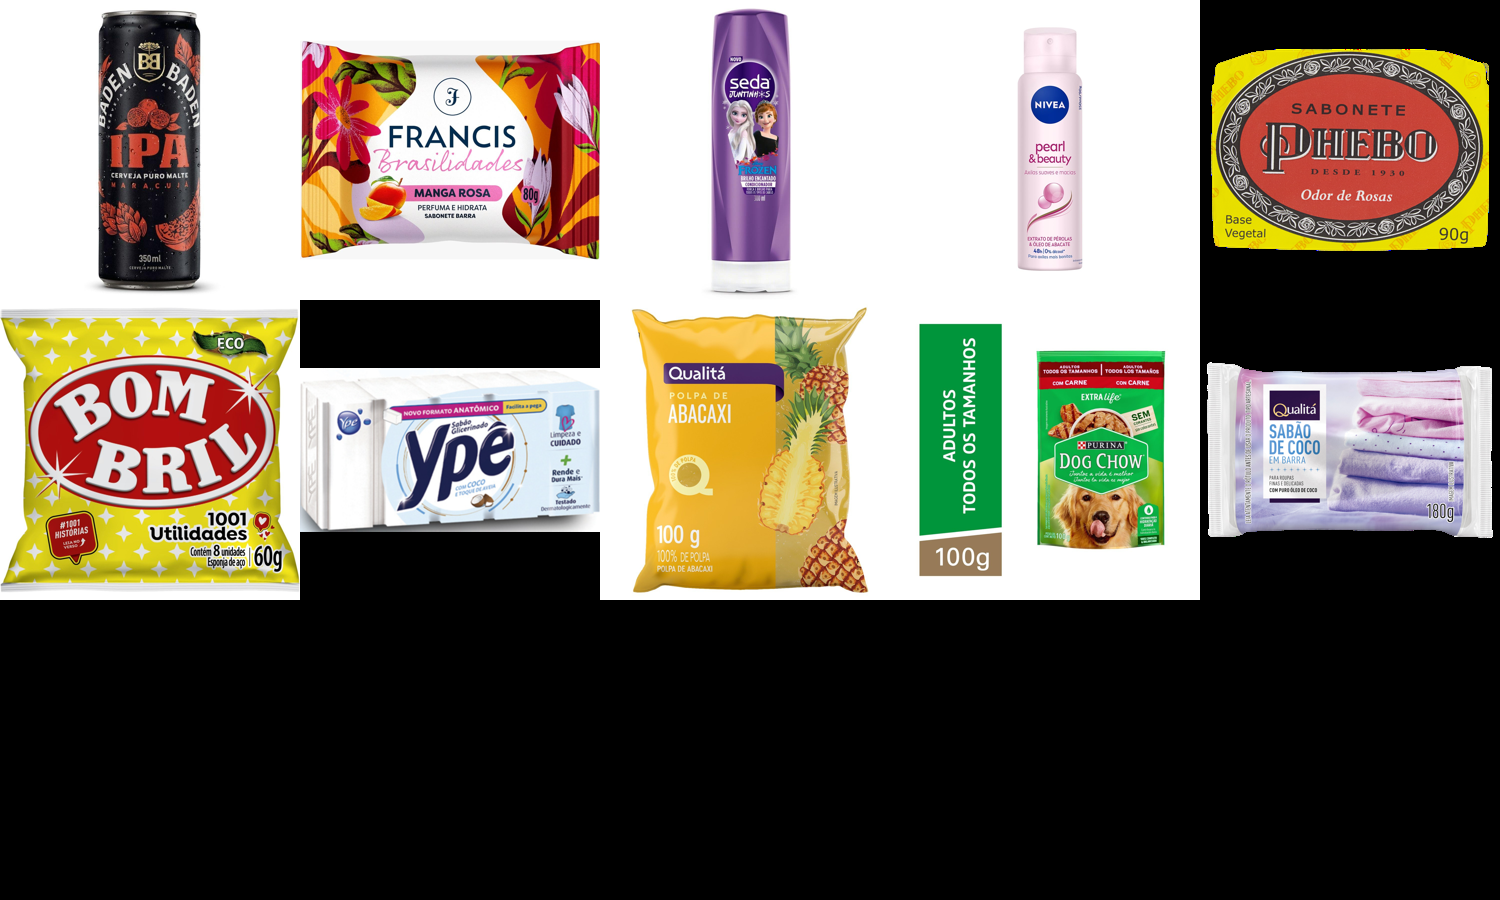

In [33]:
mosaic(best_individual)